In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

import sklearn
import os
import duckdb
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda, ReLU

from keras.losses import Loss, mse, MeanSquaredError
from keras.optimizers import Optimizer, Adam
from keras.regularizers import L2
from keras.metrics import Mean, MeanAbsoluteError
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

from sklearn.dummy import DummyRegressor

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Geospatial 
from geopy import distance
import geopandas as gpd

np.random.seed(42)
tf.random.set_seed(42)

# Outline

- [**Data Preparation**](#data-preparation)
    - [**Handling Some Outliers**](#handling-some-outliers)

# Data Preparation

We gonna use a bash script to automate the download of data from [NYC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) for yellow taxi trips in the year 2023. The bash script is the following:

```bash
# Shell exit immediately if a command exits with a error
set -e

# Args to pass when running the script
# Usage: ./download_data.sh {1} {2}
TAXI_TYPE=$1  # First argument: Taxi type ("yellow" or "green")
YEAR=$2       # Second argument: Year (e.g., 2022 or 2023)
URL_PREFIX="https://d37ci6vzurychx.cloudfront.net/trip-data"

# Loop through all months of the year
for MONTH in {1..12}; do
  # Format integers to have 2 digits for month (e.g., 01, 02)
  FMONTH=`printf "%02d" ${MONTH}`
  # Construct URL for the monthly data file
  URL="${URL_PREFIX}/${TAXI_TYPE}_tripdata_${YEAR}-${FMONTH}.parquet"

  # Define local storage path structure
  LOCAL_PREFIX="data/raw/${TAXI_TYPE}/${YEAR}/${FMONTH}"
  LOCAL_FILE="${TAXI_TYPE}_tripdata_${YEAR}_${FMONTH}.parquet"
  LOCAL_PATH="${LOCAL_PREFIX}/${LOCAL_FILE}"

  # Output the download process
  echo "downloading ${URL} to ${LOCAL_PATH}"
  # Create the specified directory and any parent directories as needed
  mkdir -p ${LOCAL_PREFIX}

  # Download the file from the URL to the specified local path
  wget ${URL} -O ${LOCAL_PATH}

done

```

Save this script file as `donwload_data.sh`. The script will create the folder `data/raw/TAXI_TYPE/YEAR/MONTH`, and in each month folder will contain a parquet file for taxi trips in NYC. Before running the script, we must make it executable:

```bash
chmod +x download_data.sh
```

The script requires two parameters: the taxi type (yellow or green) and the year. To run the script we use the following command:

```bash
./download_data.sh yellow 2023
```

We should see a three directory like the following by typing `tree data` (is necessary to install tree command: `sudo apt-get install tree`):

```
data
├── raw
│   └── yellow
│       ├── 2023
│       │   ├── 01
│       │   │   └── yellow_tripdata_2023_01.parquet
│       │   ├── 02
│       │   │   └── yellow_tripdata_2023_02.parquet
│       │   ├── 03
│       │   │   └── yellow_tripdata_2023_03.parquet
│       │   ├── 04
│       │   │   └── yellow_tripdata_2023_04.parquet
│       │   ├── 05
│       │   │   └── yellow_tripdata_2023_05.parquet
│       │   ├── 06
│       │   │   └── yellow_tripdata_2023_06.parquet
│       │   ├── 07
│       │   │   └── yellow_tripdata_2023_07.parquet
│       │   ├── 08
│       │   │   └── yellow_tripdata_2023_08.parquet
│       │   ├── 09
│       │   │   └── yellow_tripdata_2023_09.parquet
│       │   ├── 10
│       │   │   └── yellow_tripdata_2023_10.parquet
│       │   ├── 11
│       │   │   └── yellow_tripdata_2023_11.parquet
│       │   ├── 12
│       │   │   └── yellow_tripdata_2023_12.parquet
```

Another necessary dataset with the locations of each taxi pickup and dropoff is the [Taxi Zone Lookup](https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv) and the [Taxi Zone Shapefile](https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip) with the coordinates in feet. Create the folder `data/external` and download both data.

Now let's create a dataset for the taxi zone lookup with the necessary features from the shapefile using geopandas. The shape file contains information about the coordinates in feet and the taxi zone lookup the id for each zone in NYC. The final dataset will have `Zone', 'longitude' and 'latitude' as the relevant features to be used, where the longitude and latitude is the centroid location for each zone from NYC map.

In [33]:
df_taxi_zones = pd.read_csv('data/external/taxi_zone_lookup.csv') 
df_taxi_zones = df_taxi_zones.dropna()

# Load the spatial data
gdf_zones = gpd.read_file('data/external/nyc-taxi-zones/taxi_zones.shp')

# Ensure the spatial data has a column that matches the DataFrame `LocationID` or `Zone`
# Let's assume the matching column in gdf_zones is 'zone_name'
gdf_zones = gdf_zones.rename(columns={'zone': 'Zone'})

# Compute centroids
gdf_zones['centroid'] = gdf_zones.geometry.centroid

# Extract longitude and latitude from the centroids
gdf_zones['longitude'] = gdf_zones.centroid.x
gdf_zones['latitude'] = gdf_zones.centroid.y

# Merge this back into your original DataFrame
df_taxi_zones = df_taxi_zones.merge(gdf_zones[['Zone', 'longitude', 'latitude']], on='Zone', how='left')

df_taxi_zones.to_csv("data/external/taxi_zone_lookup_feet.csv", index=False)
display(df_taxi_zones.head())

,LocationID,Borough,Zone,service_zone,longitude,latitude
0,1,EWR,Newark Airport,EWR,9.359968e+05,191376.749531
1,2,Queens,Jamaica Bay,Boro Zone,1.031086e+06,164018.754403
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,1.026453e+06,254265.478659
3,4,Manhattan,Alphabet City,Yellow Zone,9.906340e+05,202959.782391
4,5,Staten Island,Arden Heights,Boro Zone,9.318714e+05,140681.351376


Now we can focus on the yellow taxi dataset, that contains almost 34933659 records for the year 2023. Because we have a very large number of records, instead of loading the data into pandas, I choose to use `duckdb` to handle the data by using SQL. 

We first create a database connection inside the folder `data/taxi_data.duckdb` and then create the necessary schema for the yellow taxi trip table. Then read each parquet file inside the month folders to create a single table with all the data from each month and another table with latitude and longitude from `taxi_zone_lookup_feet.csv` that was created. The result should be a table containing 34933659 records named `yellow_taxi_2023_full` and a table `taxi_zone_lookup_coord` for the coordinate zones in foots.

In [34]:
# Connect to DuckDB
conn = duckdb.connect(database=f"data/taxi_data.duckdb", read_only=False)

# Define a schema for the table for parquet file
conn.sql("""
CREATE OR REPLACE TABLE yellow_taxi_2023_full (
VendorID INTEGER,         
tpep_pickup_datetime TIMESTAMP,
tpep_dropoff_datetime TIMESTAMP,
passenger_count FLOAT,       
trip_distance FLOAT,       
RatecodeID FLOAT,       
store_and_fwd_flag TEXT,        
PULocationID INTEGER,         
DOLocationID INTEGER,         
payment_type INTEGER,         
fare_amount FLOAT,       
extra FLOAT,       
mta_tax FLOAT,       
tip_amount FLOAT,       
tolls_amount FLOAT,       
improvement_surcharge FLOAT,       
total_amount FLOAT,       
congestion_surcharge FLOAT,       
airport_fee FLOAT 
);
""")

# table for geographical coordinates
conn.sql(
""" 
CREATE OR REPLACE TABLE taxi_zone_lookup_coord AS
    SELECT 
        LocationID,
        latitude,	
        longitude,
    FROM read_csv_auto('data/external/taxi_zone_lookup_feet.csv')
"""
)

root_dir = "data/raw/yellow/2023"
# Insert data directly into a DuckDB table from `.parquet` files
for month in sorted(os.listdir(root_dir)):
    month_path = os.path.join(root_dir, month)
    if os.path.isdir(month_path):
        for file in os.listdir(month_path):
            # concatenates the directory path with file name
            file_path = os.path.join(month_path, file)
            if file.endswith(".parquet"):
                # Using DuckDB SQL to read `.parquet` directly into a table
                conn.sql(f"""
                    COPY yellow_taxi_2023_full 
                    FROM '{file_path}' (FORMAT 'PARQUET');
                """)


conn.sql(
"""
SELECT COUNT(*) AS yellow_taxi_2023_count
FROM yellow_taxi_2023_full
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────────┐
│ yellow_taxi_2023_count │
│         int64          │
├────────────────────────┤
│               38310226 │
└────────────────────────┘

In [35]:

conn.sql(
"""
SHOW TABLES
""")
    

┌────────────────────────┐
│          name          │
│        varchar         │
├────────────────────────┤
│ taxi_zone_lookup_coord │
│ yellow_taxi_2023       │
│ yellow_taxi_2023_full  │
└────────────────────────┘

We can see that the number of instances for each month is balanced but there is some outliers, probably inserted by mistake that needs to be removed. We can see trips for years like, for example, 2021, 2002, 2003 that don't make sense, given that the dataset contains only data from 2023:

In [36]:
conn.sql(
"""
SELECT
    strftime('%Y-%m', tpep_pickup_datetime) AS month,
    COUNT(*) AS count
FROM yellow_taxi_2023_full
GROUP BY month
ORDER BY month
""")

┌─────────┬─────────┐
│  month  │  count  │
│ varchar │  int64  │
├─────────┼─────────┤
│ 2001-01 │       6 │
│ 2002-12 │      11 │
│ 2003-01 │       6 │
│ 2008-12 │      23 │
│ 2009-01 │      15 │
│ 2014-11 │       1 │
│ 2022-10 │      11 │
│ 2022-12 │      25 │
│ 2023-01 │ 3066726 │
│ 2023-02 │ 2914003 │
│ 2023-03 │ 3403660 │
│ 2023-04 │ 3288248 │
│ 2023-05 │ 3513664 │
│ 2023-06 │ 3307259 │
│ 2023-07 │ 2907093 │
│ 2023-08 │ 2824201 │
│ 2023-09 │ 2846741 │
│ 2023-10 │ 3522269 │
│ 2023-11 │ 3339731 │
│ 2023-12 │ 3376527 │
│ 2024-01 │       6 │
├─────────┴─────────┤
│      21 rows      │
└───────────────────┘

Let's create a new `yellow_taxi_2023` table by selecting a random sample of 1.5 million records from the 2023 dataset, which contains more than 34.9 million records. Since the monthly data is balanced, random sampling ensures that the statistical characteristics of the entire dataset are preserved.

To add the geographic coordinates for the dropoff and pickup locations, we use the `taxi_zone_lookup_coord` table for the `PULocationID` and `DOLocationID` with an inner join. This join allows us to append the exact latitude and longitude for both the pickup and dropoff locations.

Finally, we filter the records to include only those from 2023, removing any potential outliers, and save the resulting table as a CSV file in the `data/raw/yellow/taxi_2023_raw.csv` folder.

In [37]:
conn.sql(
"""
CREATE OR REPLACE TABLE yellow_taxi_2023 AS
SELECT
    yt2023.tpep_pickup_datetime AS pickup_datetime,
    yt2023.tpep_dropoff_datetime AS dropoff_datetime,
    pickup_zone.latitude AS pickup_latitude,
    pickup_zone.longitude AS pickup_longitude,
    dropoff_zone.latitude AS dropoff_latitude,
    dropoff_zone.longitude AS dropoff_longitude
FROM 
    (SELECT 
        tpep_pickup_datetime,
        tpep_dropoff_datetime, 
        PULocationID,
        DOLocationID,
        strftime('%Y-%m', tpep_pickup_datetime) AS month
    FROM yellow_taxi_2023_full
    WHERE strftime('%Y', tpep_pickup_datetime) = '2023'
    ORDER BY RANDOM()
    LIMIT 2000000) AS yt2023
INNER JOIN 
    taxi_zone_lookup_coord AS pickup_zone
        ON pickup_zone.LocationID = yt2023.PULocationID
INNER JOIN 
    taxi_zone_lookup_coord AS dropoff_zone
        ON dropoff_zone.LocationID = yt2023.DOLocationID;
"""
)

# Save the result table as csv file
conn.sql(
"""
SELECT * 
FROM yellow_taxi_2023
""").df().to_csv('data/raw/yellow/taxi_2023_raw.csv', index=False)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Feature Engineering

Now that we have the dataset with just 1.5 million records and the correct pickup and dropoff coordinates for the NYC zones, it is time to create some useful features to train our neural networks. 


First, we preprocess the datetime columns to create the `min_of_day`, `day_of_week`, `day_of_year` and `trip_duration` features. The `trip_duration` will be the target variables that we aim to predict in the regression model using a simple Neural Network and a Bayesian Neural Network. The other features are the dependent variables used as input for the models. After creating these features, we remove the original datetime columns, as they are no longer needed for training the neural network

In [38]:
df_taxi= pd.read_csv('data/raw/yellow/taxi_2023_raw.csv')

In [39]:
#convert to datetime for easier manipulation
df_taxi['pickup_datetime'] = df_taxi['pickup_datetime'].str.slice(0, 16)
df_taxi['pickup_datetime'] = pd.to_datetime( df_taxi['pickup_datetime'], utc = True, format = '%Y-%m-%d %H:%M')

df_taxi['dropoff_datetime'] = df_taxi['dropoff_datetime'].str.slice(0, 16)
df_taxi['dropoff_datetime'] = pd.to_datetime( df_taxi['dropoff_datetime'], utc = True, format = '%Y-%m-%d %H:%M')

# Minutes in  a day : 0-1440
df_taxi['min_of_day'] = (60*df_taxi['pickup_datetime'].dt.hour + df_taxi['pickup_datetime'].dt.minute)
# Days in a week: 0-6, where 0 is Monday and 6 Sunday
df_taxi['day_of_week'] = df_taxi['pickup_datetime'].dt.dayofweek
# Days in a year: 1-365 (or 366)
df_taxi['day_of_year'] = df_taxi['pickup_datetime'].dt.dayofyear
# Time of the  trip
df_taxi['trip_duration'] = (df_taxi['dropoff_datetime']- df_taxi['pickup_datetime']).dt.seconds

# Remove unnecessary datetime columns
df_taxi.drop('pickup_datetime', axis = 1, inplace = True)
df_taxi.drop('dropoff_datetime', axis = 1, inplace = True)


display(df_taxi.head())
print(df_taxi.shape)

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,min_of_day,day_of_week,day_of_year,trip_duration
0,212002.893036,988362.833436,216099.139768,988628.060047,77,6,64,540
1,212491.935842,992439.560878,209039.353890,990763.615736,773,0,268,600
2,232321.290548,997734.645233,234186.326872,994834.787253,1394,6,36,1020
3,218166.434353,996787.663055,223005.988409,997817.919661,1235,2,67,420
4,204630.607988,984976.121744,211948.912400,984272.778633,1047,5,14,960


(1967531, 8)


In [40]:
# Save the dataset with new features
df_taxi.to_parquet("data/raw/yellow/taxi_2023_raw.parquet", index=False)

## Handling Spatial and Temporal Outliers

The boxplot for detecting outliers relies on the assumption that the data has a distribution close to normal (Gaussian), which is often not true with geospatial coordinates due to their unique patterns influenced by urban roads and traffic. Therefore, we will use a different approach to identify outliers in the location features.

For pickup and dropoff locations, the strategy is to use geospatial data using the taxi [Taxi Zone Shapefile](https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip) to identify with any points falls outside the boundaries of NYC map as outliers.

In [41]:
df_taxi = pd.read_parquet('data/raw/yellow/taxi_2023_raw.parquet')

In [42]:
def plot_points_map(df, gdf_map, geometry_col, ax, title='', 
                    color_map='beige', color_points='black'):
    """
    Plots a map with points from a DataFrame with coordinates.

    Parameters:
    - df: DataFrame with the coordinates to plot.
    - gdf_map: GeoDataFrame of the map boundaries.
    - geometry_col: GeoDataFrame column with geometry data.
    - ax: Matplotlib Axes object to plot on.
    - title: Title of the plot.
    - color_map: Color for the map.
    - color_points: Color for the points.
    """
    # convert to the same coordinate reference system
    gdf_points = gpd.GeoDataFrame(df, geometry=geometry_col)
    # convert to the same coordinate reference system
    gdf_points.crs = gdf_map.crs
        
    # Plot the map and the points
    gdf_map.plot(ax = ax, color=color_map, edgecolor='grey')
    gdf_points.plot(ax =ax, markersize=20, color = color_points, marker = 'x')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_title(title, fontsize=20)

    return df

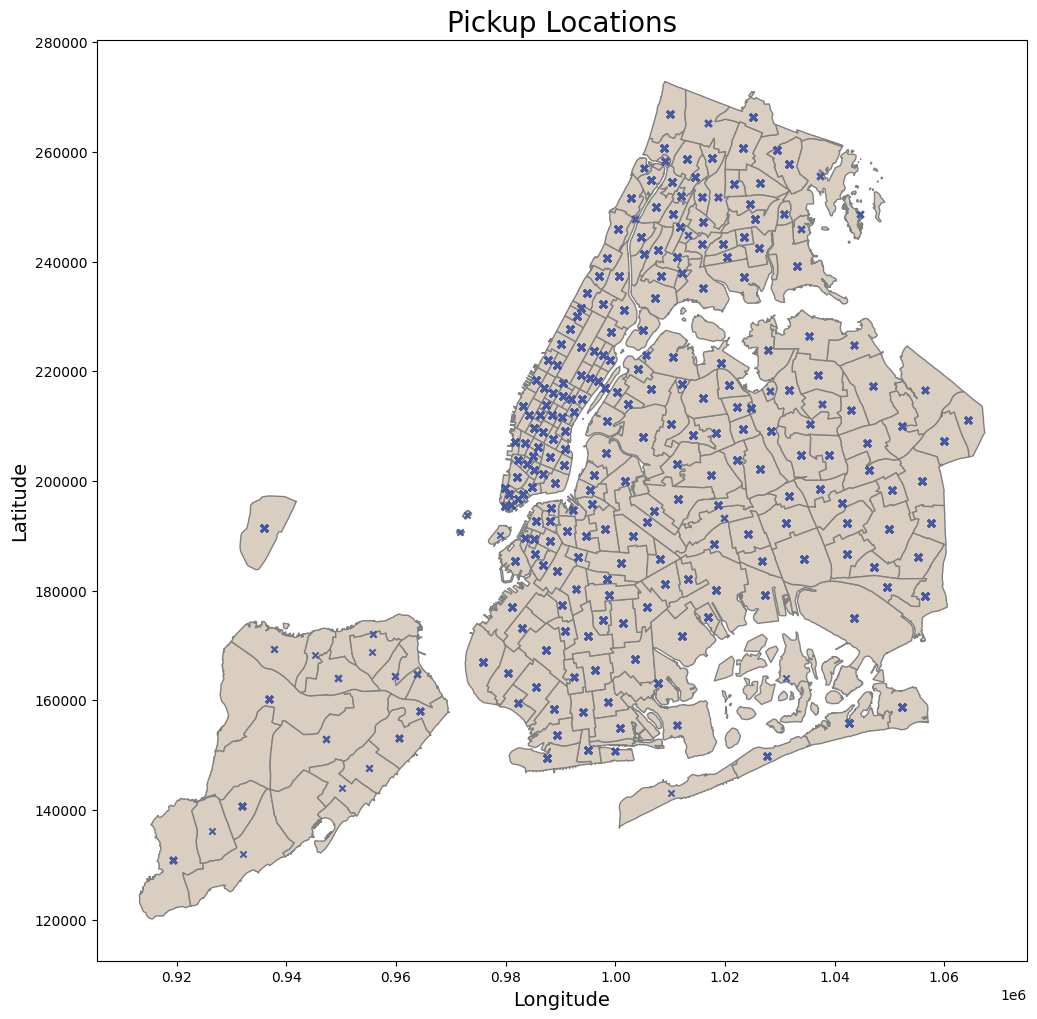

In [43]:
# path of shape file
nybb_path = 'data/external/nyc-taxi-zones/taxi_zones.shp'
nyc_boundary = gpd.read_file(nybb_path)

# Creating the geometry for points
geometry = gpd.points_from_xy(df_taxi['pickup_longitude'], df_taxi['pickup_latitude'])

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 12))
pickup_within_nyc = plot_points_map(    df = df_taxi, gdf_map = nyc_boundary, 
                                        geometry_col = geometry, ax = ax, title =  'Pickup Locations',
                                        color_map= '#d9cebfff', color_points= '#4759A1') 

# Showing the plot
plt.show()


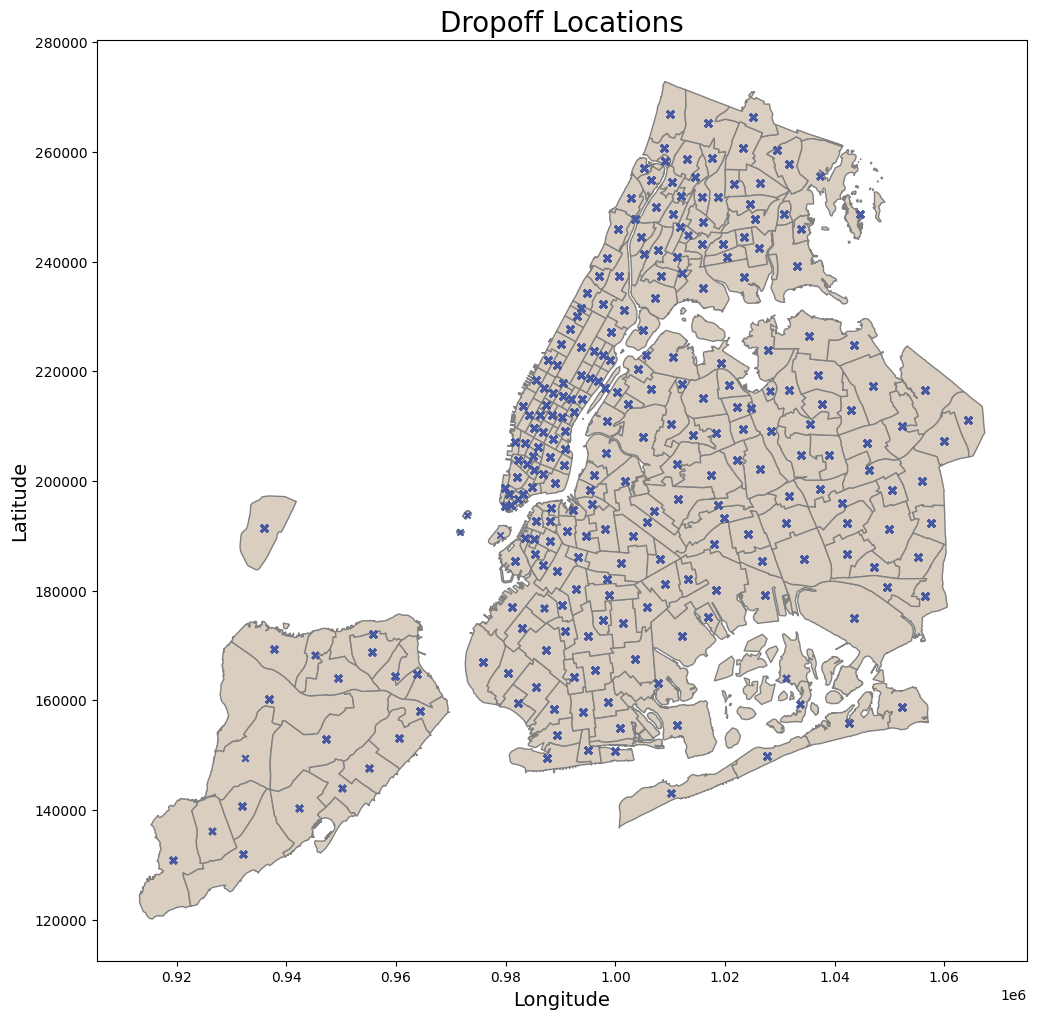

In [44]:
geometry = gpd.points_from_xy(df_taxi['dropoff_longitude'], 
                                df_taxi['dropoff_latitude'])

fig, ax = plt.subplots(figsize=(12, 12))
dropoff_within_nyc = plot_points_map(    df = df_taxi, gdf_map = nyc_boundary, 
                                                geometry_col = geometry, ax = ax, title =  'Dropoff Locations',
                                                color_map= '#d9cebfff', color_points= '#4759A1')
plt.show()

By checking the pickup and dropoff zones, it can be observed that all points are coherent, and there are no outliers for the locations.

To visualize the temporal outliers from trip duration, a boxplot combined with a bar plot for the distributions will be used.

In [45]:
def boxplot_stats(series, whis = 1.5):
    """
    Calculate the statistics for a box plot.

    Returns:
    dict: A dictionary containing the quartiles, IQR, and whisker limits.
    """
    Q1 = series.quantile(0.25)
    Q2 = series.quantile(0.50)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_whisker = Q1 - whis * IQR
    upper_whisker = Q3 + whis * IQR

    return {
        'Q1': Q1,
        'Q2': Q2,
        'Q3': Q3,
        'IQR': IQR,
        'lower_whis': lower_whisker,
        'upper_whis': upper_whisker
    }


def plot_distribution_boxplot(  series, ax1, ax2, title='', label='', log1p=True, 
                                draw_quartiles=True, kde=True):
    """
    Plot the distribution and boxplot of a series on given axes.

    Args:
    - series (pandas.Series): The series to plot.
    - ax1 (matplotlib.axes.Axes): The axes for the histogram.
    - ax2 (matplotlib.axes.Axes): The axes for the boxplot.
    - title (str): The title of the plot.
    - label (str): The label for the x-axis.
    - log (bool): If True, applies log1p transformation to the series.
    - draw_quartiles (bool): If True, draws quartile lines on the histogram.
    - kde (bool): If True, plots a KDE over the histogram.
    """
    if log1p:
        series = np.log1p(series)
    stats = boxplot_stats(series)

    sns.histplot(   series, bins=40, linewidth=0.5, color='#dfdc7bff', alpha=0.2,
                    ax=ax1, kde=kde, line_kws={'lw': 3})
    ax1.set_title(f'{title} Histogram', fontsize=15)
    ax1.set_xlabel(label, fontsize=14)
    ax1.set_ylabel('Count', fontsize=14)

    sns.boxplot(data=series, color='#dfdc7bff', ax=ax2,
                fliersize=3, flierprops={'color': '#50566dff', 'markeredgecolor': '#50566dff'})
    
    ax2.set_title(f'{title} Boxplot', fontsize=15)
    ax2.set_ylabel(label, fontsize=14)

    if draw_quartiles:
        quartiles = [stats['Q1'], stats['Q3'], stats['lower_whis'], stats['upper_whis']]
        for line in quartiles:
            ax1.axvline(line, color='#50566dff', linestyle='--', alpha=1, lw=2)
            y_center = ax1.get_ylim()[1] / 2
            ax1.text(   line, y_center, f'{line:.2f}',
                        fontsize=18, color='black', va='center', ha='right', rotation=90)



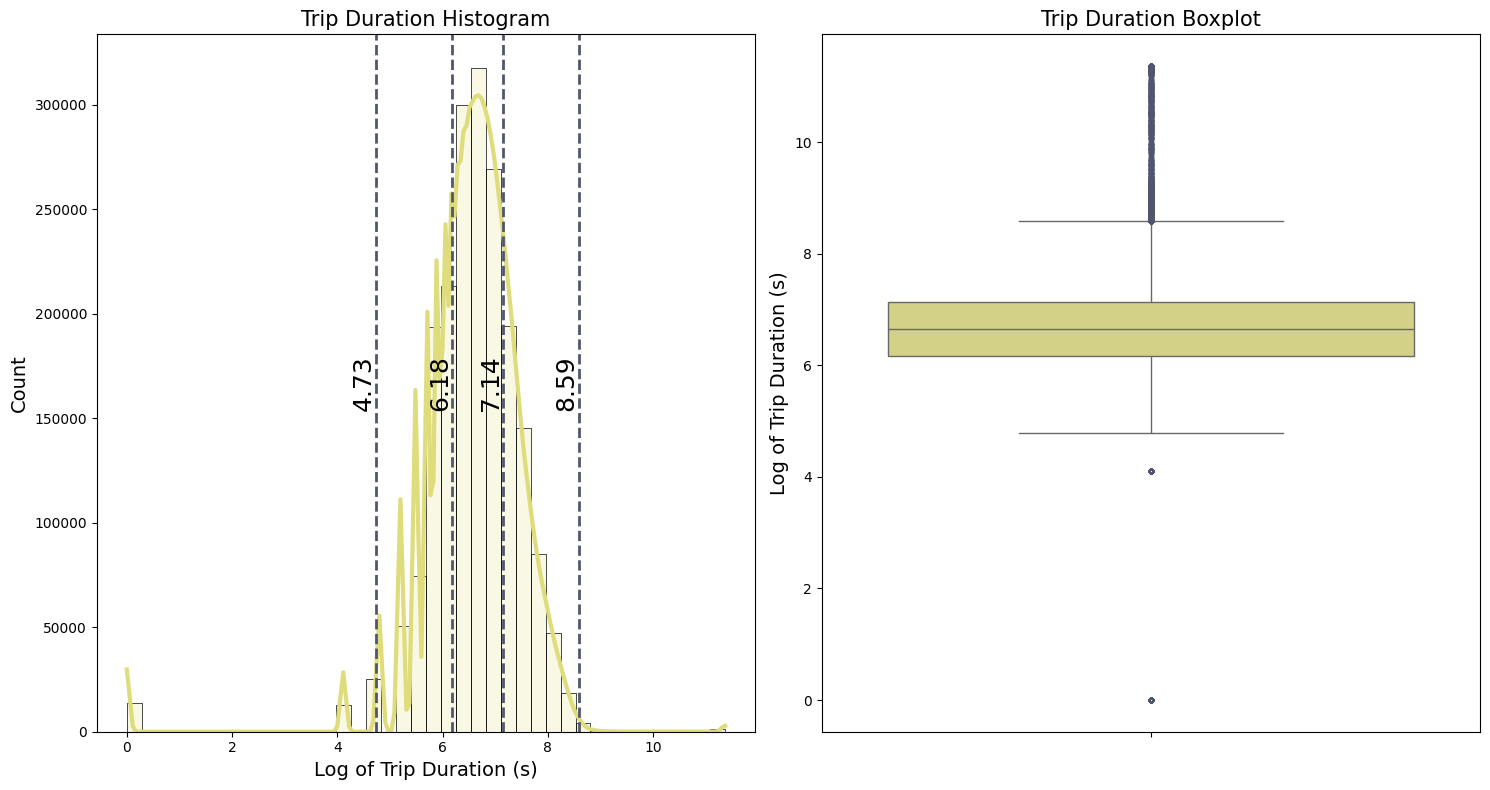

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plot_distribution_boxplot(  df_taxi['trip_duration'], ax1, ax2,
                            title='Trip Duration', label='Log of Trip Duration (s)')

plt.tight_layout()
plt.show()

Because of the high values and possible zeros in the target feature `trip_duration`, we apply the logarithmic transformation $\log(x+1)$. This transformation reduces the effect of outliers and the overall variance in the dataset. Additionally, $\log(x+1)$ is particularly useful for handling zero values because the transformation ensures that zero values are transformed to zero instead of resulting in undefined values. The histogram, illustrated in the first plot, resembles a bell curve after applying this transformation. From the boxplot, we can see:

- The first and third quartiles ($Q_1$ and $Q_3$) representing the 25th and 75th percentiles, are:

  - $Q_1 = 6.18$
  - $Q_3 = 7.14$

- The interquartile range (IQR) is the difference between the third and first quartiles:
  - IQR = $Q_3 - Q_1 = 0.96$

- The whiskers indicate the range of the data:
  - The lower whisker :  $Q_1 - 1.5 IQR = 4.74$
  - The upper whisker :  $Q_3 + 1.5 IQR = 8.58$

Data points outside the whiskers are potential outliers that need further validation. For better intuition, we convert these whisker values from the log scale back to the original scale in terms of hours ($\text{Hours} = \text{Seconds}/3600$ ):

$$\frac{\exp(4.74) - 1}{3600} \approx  0.031 ~~\text{hours}$$
$$\frac{\exp(8.58) - 1}{3600} \approx  1.48 ~~\text{hours}$$

The lower whisker corresponds to approximately 1.4 minutes, which is very short for a taxi trip duration, suggesting that these could be errors or special cases like short trips to airport to carry bagge. The upper whisker suggests a more plausible trip duration of about 1.32 hours, but with very unrealistic high values with more than 20 hours of duration. 

In [47]:
def count_outliers(series, whis = 1.5):
        """
        Count the number of upper and lower outliers in the series and print their percentages.

        Args:
        series (pd.Series): Series for which to count outliers.

        Returns:
        (pd.Series, pd.Series): Two boolean series, one for upper outliers and one for lower outliers.
        """

        stats = boxplot_stats(series, whis)


        upper_outliers = (series > stats['upper_whis'])
        lower_outliers = (series < stats['lower_whis'])

        # Percentage of outliers 
        percentage_upper = upper_outliers.sum() / len(series) * 100
        percentage_lower = lower_outliers.sum() / len(series) * 100

        print(  f'\nPotential upper outliers: {upper_outliers.sum()} '
                f'({percentage_upper:.2f}% of the dataset)')

        print(  f'\nPotential lower outliers: {lower_outliers.sum()} '
                f'({percentage_lower:.2f}% of the dataset)')

        return upper_outliers, lower_outliers


log_trip_duration = np.log1p(df_taxi['trip_duration'])
upper_duration_outliers, lower_duration_outliers = count_outliers(log_trip_duration)


Potential upper outliers: 4691 (0.24% of the dataset)

Potential lower outliers: 26457 (1.34% of the dataset)


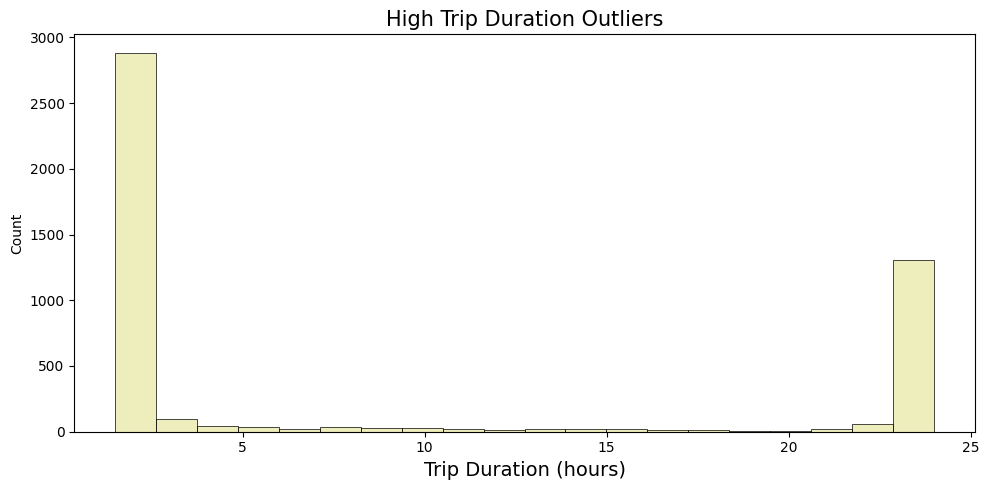

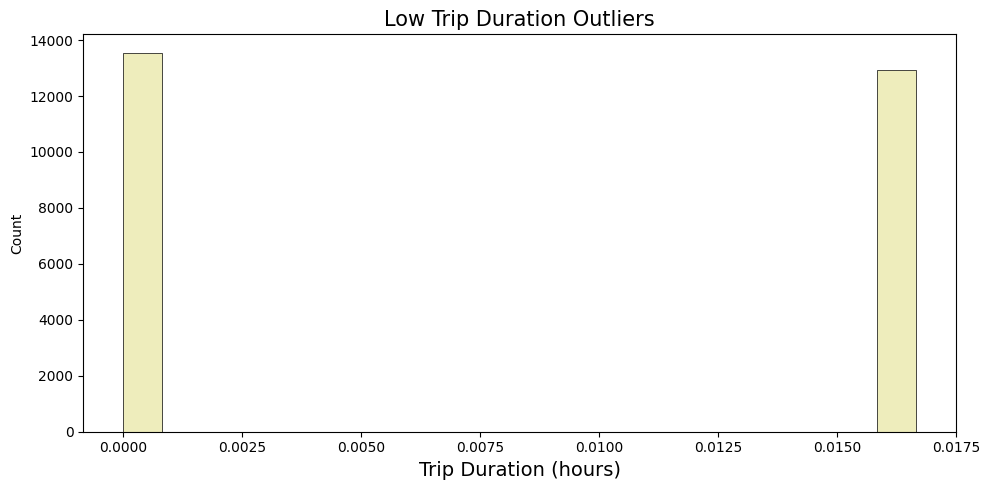

In [48]:
# bar plot for upper whisker
upper_outliers = df_taxi[upper_duration_outliers]['trip_duration'].reset_index(drop=True)/3600

fig, axes = plt.subplots(1, 1, figsize= (10, 5))
sns.histplot(  upper_outliers, bins=20, linewidth=0.5, color='#dfdc7bff', alpha=0.5)
axes.set_title(f'High Trip Duration Outliers', fontsize=15)
axes.set_xlabel('Trip Duration (hours)', fontsize=14)
plt.tight_layout()
plt.show()


# bar plot for lower whisker
lower_outliers = df_taxi[lower_duration_outliers]['trip_duration'].reset_index(drop=True)/3600

fig, axes = plt.subplots(1, 1, figsize= (10, 5))
sns.histplot(  lower_outliers, bins=20, linewidth=0.5, color='#dfdc7bff', alpha=0.5)
axes.set_title(f'Low Trip Duration Outliers', fontsize=15)
axes.set_xlabel('Trip Duration (hours)', fontsize=14)
plt.tight_layout()
plt.show()

Based on the observation plots, it is reasonable to drop records lower then one minute and higher then 4 hours:

In [49]:
## Select only trip duration above the lower whisker (above 1 minute)
df_taxi = df_taxi[df_taxi['trip_duration'] >= 60].copy()


## Select only trip duration lower then 4 hours
df_taxi = df_taxi[df_taxi['trip_duration'] <= 4 * 3600].copy()

df_taxi.shape

(1952301, 8)

To optimize the performance of the neural network models, it is important to transform and normalize the data. Log transformation and normalization help in achieving better results by addressing skewness, reducing the impact of outliers, and ensuring that all features contribute equally to the model.

First, a logarithmic transformation is applied to the target variable `trip_duration`. Since zero values have been removed from the dataset, the standard logarithmic transformation can be safely used without encountering undefined values. Next, normalization is applied to the other dependent variables. Normalizing the data ensures that all features have a mean of 0 and a standard deviation of 1

In [50]:
# Transform target column using log1p
df_taxi['trip_duration'] = np.log(df_taxi['trip_duration'])

# Normalize data for the BNN
df_taxi = (df_taxi - df_taxi.mean()) / df_taxi.std()

Let's check how the variables are distributed:

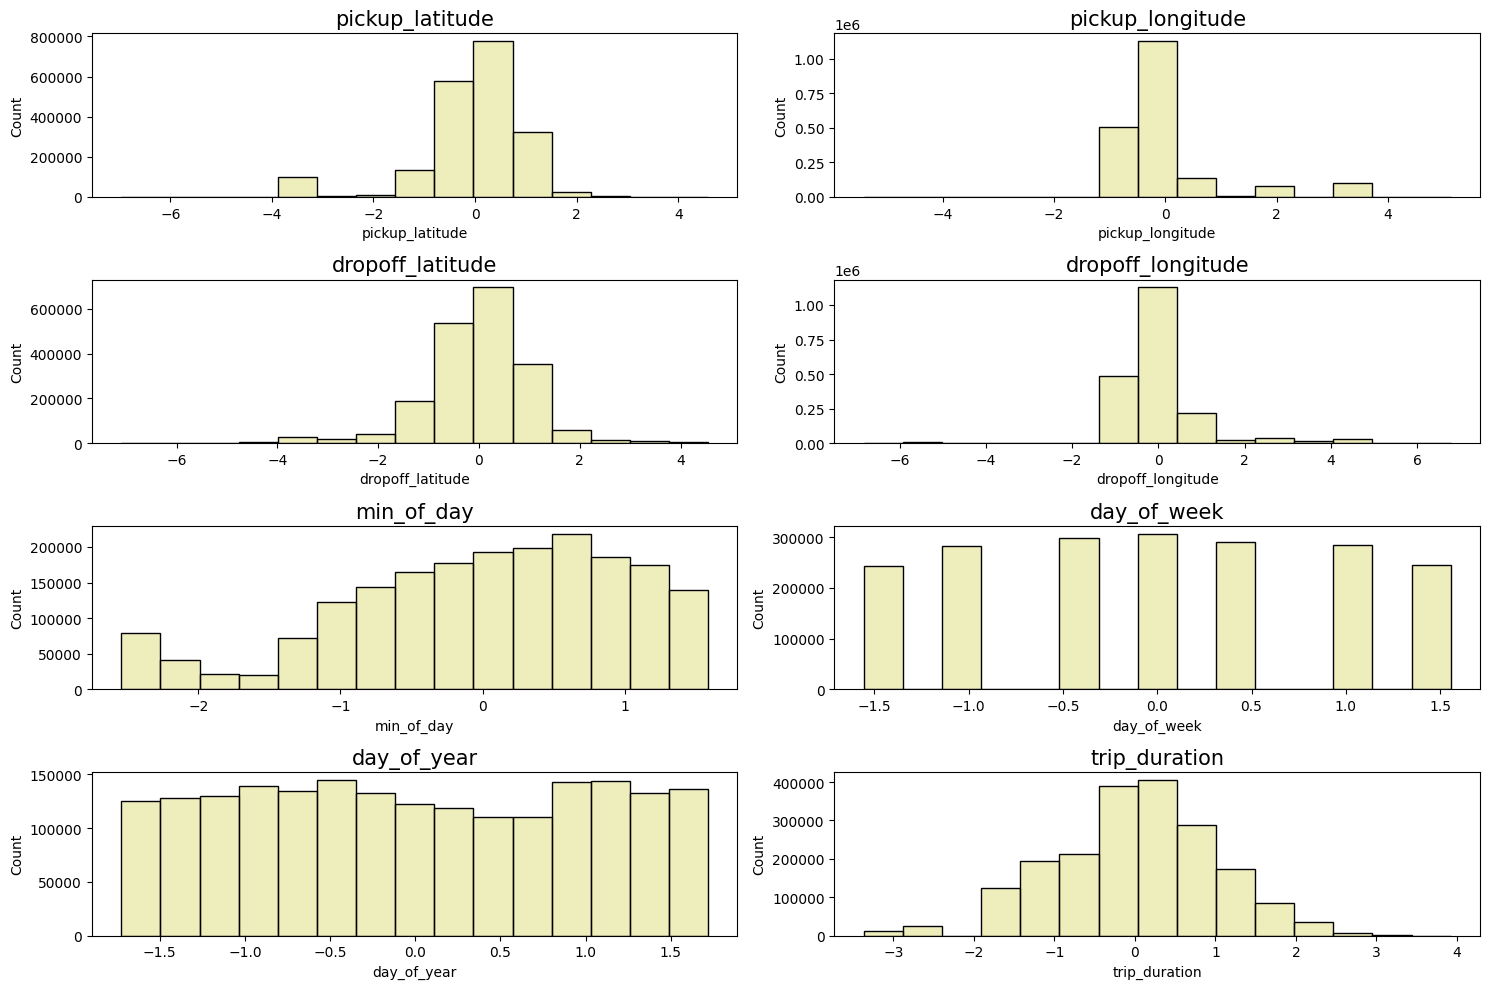

In [51]:
# Adjust the layout to 3x3 to handle 9 plots
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(4, 2, i + 1)  # Create a 3x3 grid
    sns.histplot(df_taxi.iloc[:, i], bins=15, linewidth=1, color='#dfdc7bff', alpha=0.5)
    plt.title(df_taxi.columns[i], fontsize=15)
plt.tight_layout()
plt.show()

The final dataset can be then saved into the `data/processed/yellow_taxi_2023.parquet` folder. This will be the data used to train our regression model to predict the yellow taxi trip duration in NYC.

In [52]:
df_taxi.to_parquet("data/processed/yellow_taxi_2023.parquet", index=False)

# Simple Neural Network

In [53]:
# Load the processed data
df_taxi = pd.read_parquet("data/processed/yellow_taxi_2023.parquet")

# Split the data into train, validation adn test
df_train_large, df_taxi_test = train_test_split(df_taxi, test_size = 0.20, random_state=42 )
df_taxi_train, df_taxi_val = train_test_split(df_train_large, train_size = 0.25, random_state=42)


print(f"Train large:{len(df_train_large)}({round(100*len(df_train_large)/ len(df_taxi), 2)}%)")
print(f"Test: {len(df_taxi_test)}({round(100*len(df_taxi_test)/len(df_taxi),2)}%)")
print(f"Train:{len(df_taxi_train)}({round(100*len(df_taxi_train)/len(df_taxi),2)}%)")
print(f"Validation: {len(df_taxi_val)}({round(100*len(df_taxi_val)/len(df_taxi),2)}%)")

# Save Target feature
Y_train = df_taxi_train['trip_duration'].values
Y_val = df_taxi_val['trip_duration'].values
Y_test = df_taxi_test['trip_duration'].values

# Drop target feature
df_taxi_train.drop('trip_duration', axis=1, inplace=True)
df_taxi_val.drop('trip_duration', axis=1, inplace=True)
df_taxi_test.drop('trip_duration', axis=1, inplace=True)

X_train = df_taxi_train.values
X_val = df_taxi_val.values
X_test = df_taxi_test.values

Train large:1561840(80.0%)
Test: 390461(20.0%)
Train:390460(20.0%)
Validation: 1171380(60.0%)


In [54]:
class NNRegressor(Model):
    def __init__(self,
                 layer_units: list = [512, 128, 64],
                 output_unit: int = 1,
                 dropout_rate: float = 0.1,
                 name="NNRegressor"):
        """
        Initialize the NNRegressor.

        Args:
            layer_units (list of int): A list of integers representing the number of units in each hidden layer.
            output_unit (int): An integer representing the number of units in the output layer.
            dropout_rate (float): A float representing the dropout rate used in each dropout layer.
            name (str): A string representing the name of the model.
        """
        super().__init__(name=name)

        self.units = layer_units
        self.output_unit = output_unit
        self.dropout_rate = dropout_rate

        # Hidden layers
        self.hidden_layers = []
        for i, unit in enumerate(layer_units):
            self.hidden_layers.append(Dense(units=unit,                                          
                                           use_bias=True,
                                           name=f'Hidden_{i}'))
            self.hidden_layers.append(BatchNormalization(name=f'BatchNorm_{i}'))
            self.hidden_layers.append(ReLU(name=f'ReLU_{i}'))
            self.hidden_layers.append(Dropout(dropout_rate, name=f'Dropout_{i}'))

        # Output layer
        self.output_layer = Dense(units=output_unit,
                                  name="Output")

    def call(self, x):
        """
        Compute the forward pass of the NNRegressor.

        Args:
            x (tf.Tensor): A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            tf.Tensor: A tensor of shape (batch_size, output_unit), containing the output of the NNRegressor.
        """

        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)

        return x


In [55]:
# Instantiate and compile the model
nn_regressor = NNRegressor()
nn_regressor.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_absolute_error')

# Train the model with explicit validation data
nn_history = nn_regressor.fit(X_train, Y_train, batch_size=1024, epochs=150, validation_data=(X_val, Y_val), verbose=1)

# Save Model
current_directory = os.getcwd()
save_dir = os.path.expanduser( current_directory + '/models/nn_regressor')
nn_regressor.save(save_dir)

Epoch 1/150
382/382 [==============================] - 8s 17ms/step - loss: 0.6158 - val_loss: 0.4811
Epoch 2/150
382/382 [==============================] - 6s 17ms/step - loss: 0.5159 - val_loss: 0.4208
Epoch 3/150
382/382 [==============================] - 6s 17ms/step - loss: 0.4819 - val_loss: 0.4095
Epoch 4/150
382/382 [==============================] - 7s 19ms/step - loss: 0.4637 - val_loss: 0.4023
Epoch 5/150
382/382 [==============================] - 7s 18ms/step - loss: 0.4514 - val_loss: 0.4002
Epoch 6/150
382/382 [==============================] - 7s 18ms/step - loss: 0.4426 - val_loss: 0.3978
Epoch 7/150
382/382 [==============================] - 7s 17ms/step - loss: 0.4356 - val_loss: 0.3951
Epoch 8/150
382/382 [==============================] - 6s 17ms/step - loss: 0.4294 - val_loss: 0.3934
Epoch 9/150
382/382 [==============================] - 6s 16ms/step - loss: 0.4254 - val_loss: 0.3912
Epoch 10/150
382/382 [==============================] - 6s 17ms/step - loss: 0.421

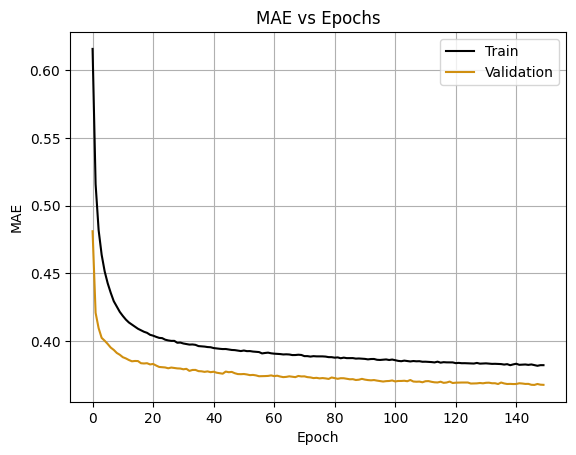

In [56]:
plt.plot(nn_history.history['loss'], label='Train', color =  'black')
plt.plot(nn_history.history['val_loss'], label='Validation', color =  "#d08f10ff" )
plt.title('MAE vs Epochs')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid()
plt.show()


In [57]:
train_mae_log = 0.38
val_mae_log = 0.37

train_mae_original = np.exp(train_mae_log)
val_mae_original = np.exp(val_mae_log)

print(f"Original scale train MAE: {train_mae_original:.2f} seconds")
print(f"Original scale validation MAE: {val_mae_original:.2f} seconds")


Original scale train MAE: 1.46 seconds
Original scale validation MAE: 1.45 seconds


After back-transforming the MAE values from the log scale, the results indicate that the predictions deviate from the actual values by a factor of approximately 1.47 for the training set and 1.45 for the validation set. This is because the log transformation turns multiplicative errors into additive ones. When exponentiating the log-scale MAE, it reflects the average multiplicative error. For an actual trip duration of 500 seconds, this means:

- Train MAE: The predictions would be off by a factor of 1.47. Therefore, $1.47 \times 500≈7351.47  \times 500≈735$ seconds.

- Validation MAE: The predictions would be off by a factor of 1.45. Therefore, $1.45 \times 500≈7251.45  \times 500≈725$ seconds.

12202/12202 [==============================] - 9s 735us/step


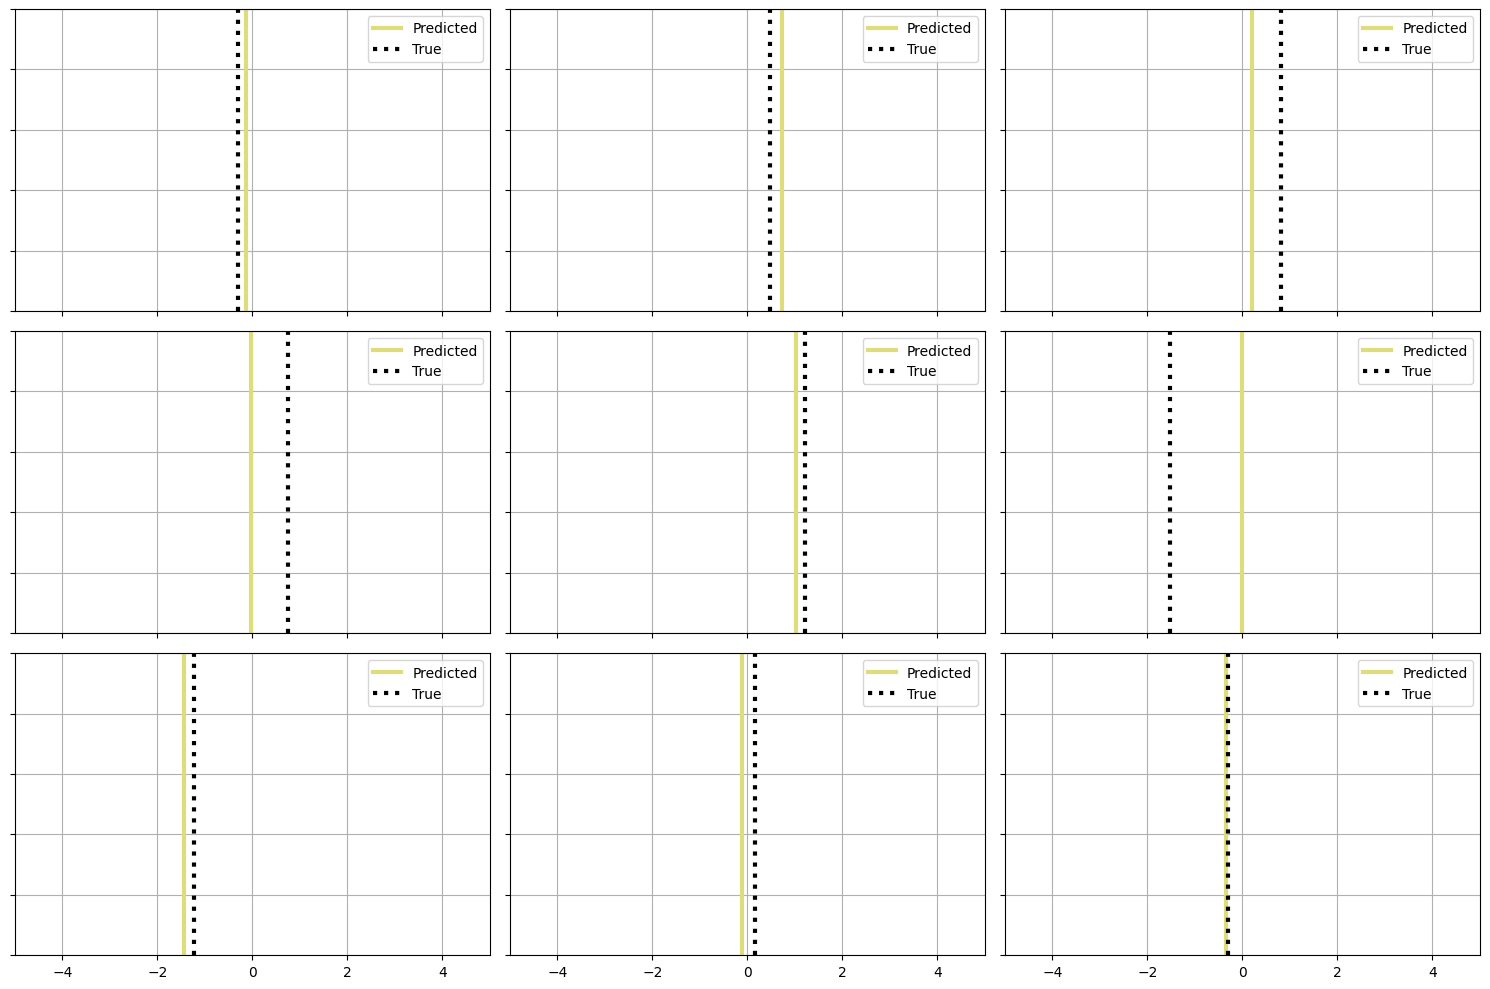

In [58]:
# Make predictions on the test set
preds = nn_regressor.predict(X_test)

# Select a sample of predictions to plot
sample_indices = np.random.choice(range(len(Y_test)), size=9, replace=False)
sample_preds = preds[sample_indices]
sample_true = Y_test[sample_indices]

# Plot true vs predicted durations
plt.figure(figsize=(15, 10)) 
for i in range(9):
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns
    plt.axvline(sample_preds[i], label='Predicted', color='#dfdc7bff', linewidth=3)
    plt.axvline(sample_true[i], ls=':', color='black', label='True', linewidth=3)
    plt.xlim([-5, 5])
    plt.legend()
    plt.gca().get_yaxis().set_ticklabels([])
    plt.grid()
    if i < 6:
        plt.gca().get_xaxis().set_ticklabels([])

plt.tight_layout()
plt.show()

The provided plot shows a comparison between predicted and true trip durations for a sample of 9 trips from the test set. Each subplot represents a single trip, showing the predicted duration as a solid line and the true duration as a dashed line.

Neural networks typically provide point estimates for predictions, meaning they output a single predicted value for each input. Point estimates do not provide information about the uncertainty or confidence in the predictions. This is a significant limitation because it means we can't quantify how confident the model is about its predictions.

For example, in a taxi trip, knowing the uncertainty in trip duration helps passengers plan their activities better. If a passenger has a flight to catch, understanding the potential range of travel times can help them decide when to leave for the airport.

# Simple Bayesian Neural Network

To incorporate uncertainty information, we will use Bayesian Neural Networks (BNNs). BNNs provide not only point estimates but also a measure of uncertainty, which allows for more informed decision-making.

Because fitting a BNN using Keras is challenging, the idea is to create the model from scratch using TensorFlow and Keras API. We first began by creating a dense variational layer that receives the number of neurons and the activation function, similar to a standard layer in TensorFlow.

To illustrate the feedforward step in a Bayesian Neural Network (BNN), consider a BNN with two layers, where  $\mathbf{x}$  is a vector consisting of  $m$  neurons in the input layer, and  $\mathbf{y}$  is a vector consisting of  $n$   neurons in the output layer:

<center><img src="figures/bnn_layer.png" width="500" height="800"></center>

For a BNN weights and biases are not just fixed values. Instead, each weight and bias is associated with a mean and a variance, which are parameters of the normal distribution from which they are sampled at each forward step. This introduces variability in the weights and biases, allowing BNNs to inherently model uncertainty. A standard approach is the reparametrization trick to sample the weight and bias values from their respective independent normal distributions and to guarantee differentiability during the backpropagation step. To further elucidate, consider the weights and biases between the input and hidden layers:

$$w_{ij} = \mu_{ij} + \sigma_{ij} \cdot \epsilon_{ij} $$
$$b_{j} = \mu_{j} + \sigma_{j} \cdot \epsilon_{j} $$


To initialize the learnable variables $\mu_{ij}$ and $\sigma_{ij}$ for the distribution of the weights and biases, we can sample random values from a truncated normal distribution, represented as $\mathcal{T}\left(0, \sqrt{\frac{2}{n+m}}\right)$. This is done within the `xavier` method of the class. This particular distribution ensures that the initialized weights and biases aren't too distant from the mean, as extreme values might negatively affect the learning process. The matrix representation for the mean and variance of weights and biases are:

$$ 
{\mu}_w =
\left( \begin{array}{cccc}
\mu_{11} & \cdots & \mu_{1n}\\
\vdots & \ddots & \vdots\\
\mu_{m1} & \cdots &\mu_{mn}
\end{array} \right)~~~~
{\Sigma}_w =
\left( \begin{array}{cccc}
\sigma_{11} & \cdots & \sigma_{1n}\\
\vdots & \ddots & \vdots\\
\sigma_{m1} & \cdots &\sigma_{mn}
\end{array} \right).
$$

and

$$ 
{\mu}_b =
\left( \begin{array}{c}
\mu_{1} \\
\vdots \\
\mu_{n}
\end{array} \right)~~~~
{\Sigma}_b =
\left( \begin{array}{c}
\sigma_{1}\\
\vdots\\
\sigma_{n}
\end{array} \right).
$$

Here, each $w_{ij}$ connects the $i$-th neuron in the input layer to the $j$-th neuron in the next layer, sampled from a normal distribution $\mathcal{N}(\mu_{ij}, \sigma_{ij})$, where $\mu_{ij}$ and $\sigma_{ij}$ are learnable parameters for the mean and standard deviation, and $\epsilon_{ij}$ is the perturbation sampled from a normal distribution $\mathcal{N}(0, 1)$. The same idea applies to the bias term $b_{j}$. In matrix notation, for all connections of the weights and biases between the two layers, we have:

$$\mathbf{W} = \mu_w + \Sigma_w \odot \epsilon_w $$
$$\mathbf{b} = \mu_b + \Sigma_b \odot \epsilon_b $$

where

$$
\mathbf{W} =
\left( \begin{array}{cccc}
w_{11} & \cdots & w_{1n}\\
\vdots & \ddots & \vdots\\
w_{m1} & \cdots &w_{mn}
\end{array} \right),~~~~
\mathbf{b} =
\left( \begin{array}{c}
b_{1}\\
\vdots\\
b_{n}
\end{array} \right)
$$

So to sample the matrix $\mathbf{W}$ for the weights of a layer, we calculate the posterior normal distribution $p(\mathbf{w}| \mathbf{x}) \sim \mathcal{N}(\mu_{w}, \Sigma_{w})$ given the input data $\mathbf{x}$.


However, there is a computational problem with this approach: the reparameterization trick can use the same noise $\epsilon_{ij}$ for the entire batch. This means that for a given batch, all the weight samples share the same noise term, which introduces correlation across different samples within the batch. This correlation leads to noisy gradient estimates because each gradient update is influenced by the same noise terms.

To address this issue, we need a way to decorrelate these samples to ensure that the noise affecting the weights and biases is different for each forward step within the batch. The [Flipout method](https://arxiv.org/abs/1803.04386) can be used for this purpose. Flipout introduces additional perturbations with random sign matrices (matrices with $\pm 1$ entries), which effectively decorrelates the samples across different forward passes within a batch.

The Flipout method uses clever perturbations to implicitly sample from the weight and bias distributions without using the same perturbation for each batch. This is achieved by creating perturbations in the input batch matrix $\mathbf{x_i}$ from the previous layer and also by multiplying the noise $\epsilon$ by random sign matrices. This ensures that the perturbations are different for each batch, reducing the correlation introduced by using the same distribution to sample the noise $\epsilon$ across the entire batch.

Flipout use a base perturbation  $\epsilon$   shared by all examples in the batch and multiplies it by a different sign matrix for each example:

$$\epsilon_i = \epsilon \odot (\mathbf{r}_i \mathbf{s}_i^T) $$

where  $\mathbf{r}_i$   and  $\mathbf{s}_i$   are random vectors whose entries are sampled uniformly from  $\pm 1$  .

Considering the previous illustration of a BNN with two layers, the feedforward step for the  $i$-th batch  $\mathbf{x_i}$   would have the following structure without Flipout:

$$
\left\{ \begin{array}{ll} 
\mathbf{\textrm{net}} = \mathbf{x_i} \cdot \mathbf{W} \\
\mathbf{y_i} = f \left(\mathbf{\textrm{net}}\right)
\end{array}\right.
$$

where  $f(.)$   is the activation function. For simplicity, we will only focus on the weight term. To sample  $\mathbf{W}$   by using the Flipout method, we would have:

$$\mathbf{W} = \mu_{w} + \Sigma_{w} \odot \epsilon_i $$

The formulation is similar to the reparameterization trick to sample the weights, with the difference being the perturbation term. Substituting in the  $\textrm{net}$   equation:

$$
\begin{align*}
\mathbf{\textrm{net}} &= \mathbf{x_i}(\mu + (\Sigma_{w} \odot \epsilon) \odot (\mathbf{r}_i \mathbf{s}_i^T))\\
&= \mathbf{x_i}\mu + (\Sigma_{w} \odot \epsilon) \odot \left((\mathbf{x_i}\odot \mathbf{s}_i^T) \odot \mathbf{r}_i)\right) 
\end{align*}
$$

This results in the following equation for a batch in the BNN using Flipout:

$$\mathbf{y_i} = f(\mathbf{x_i}\mu + (\Sigma_{w} \odot \epsilon) \odot \left((\mathbf{x_i}\odot \mathbf{s}_i^T) \odot \mathbf{r}_i)\right) $$


This Flipout method is calculated in our `call` method for the class DenseFlipout.


For the losses computed in each layer, within the method `layer_losses`, we will use the Kullback-Leibler (KL) Divergence (Relative Entropy). The KL divergence is a measure that quantifies the difference or "distance" between two probability distributions. Given two probability distributions for the weights, the posterior distribution $p(\mathbf{W}| \mathbf{x}) \sim \mathcal{N}(\mu_{w}, \Sigma_{w})$ and the prior distribution $q(\mathbf{W}) \sim \mathcal{N}(0, 1)$, the KL divergence can be defined using the following equation:


$$D_{KL}(q||p) = \int q(\mathbf{W})\log{\bigg(\frac{q(\mathbf{W})}{p(\mathbf{W}| \mathbf{x})}\bigg)} dW$$

The KL divergence can be interpreted as the expected logarithmic difference between the two probability distributions, with the expectation taken over the values of $\mathbf{W}$ according to the posterior distribution $p(\mathbf{W}| \mathbf{x})$. In essence, the KL divergence quantifies the amount of information lost when we approximate the posterior distribution $p(\mathbf{W}| \mathbf{x})$ using the prior distribution $q(\mathbf{W})$.

$$D_{KL}(p||q) =\mathbb{E}\bigg[\log{\bigg(\frac{q(\mathbf{W})}{p(\mathbf{W}| \mathbf{x})}\bigg)}\bigg] $$

By encouraging the posterior distribution to remain close to the prior (standard normal), we are effectively regularizing the network. This regularization helps to prevent overfitting by penalizing weights that deviate too far from zero, thereby favoring simpler models that generalize better. The goal is to update this prior belief to a posterior distribution after observing the data $\mathbf{x}$. The KL divergence term in the loss function ensures that the learned weights do not stray too far from our prior belief unless supported by the data.

In [59]:
class DenseFlipout(Layer):
    def __init__(self, units, activation=None, name = 'DenseVariational'):
        
        """
        Initializes the custom variational dense layer with flipout.

        Args:
            units (int): The number of neurons in the dense layer.
            activation (str or callable, optional): The activation function to use on the layer's output. 
                Defaults to None, which means no activation is applied.
            name (str): The name of the layer.
        """
              
        super(DenseFlipout, self).__init__(name = name)

        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def xavier(self, shape):

        """
        Performs Xavier initialization for the layer's weights and biases.

        Args:
            shape (tuple): The shape of the tensor to initialize.

        Returns:
            tf.Tensor: A tensor with the specified shape initialized using the Xavier initialization method.
        """
        xavier_dist = tf.random.truncated_normal(shape=shape, mean=0.0, stddev=np.sqrt(2.0 / sum(shape)))

        return xavier_dist

    def build(self, input_shape):

        """
        Builds the variational dense layer by initializing weights and biases with their respective means and standard deviations.

        Args:
            input_shape (tuple): The shape of the input to the layer, used to determine the weight shapes.
        """
        self.d_in = input_shape[-1]
        # Initializing mean and standard deviation for weights and biases to represent their posterior distributions.
        self.w_loc = tf.Variable(self.xavier((self.d_in, self.units)), name='w_loc')
        self.w_std = tf.Variable(self.xavier((self.d_in, self.units)) - 6.0, name='w_std')
        self.b_loc = tf.Variable(self.xavier((1, self.units)), name='b_loc')
        self.b_std = tf.Variable(self.xavier((1, self.units)) - 6.0, name='b_std')

    def call(self, x, training = True):

        """
        Performs the forward pass through the layer, either stochastically if in training mode, or deterministically.

        Args:
            x (tf.Tensor): Input tensor to the layer.
            training (bool): Boolean flag indicating whether the layer is in training mode.

        Returns:
            tf.Tensor: Output tensor after applying the variational dense layer.
        """

        if training: # Stochastic forward pass (sampling process)
            
            # random sign matrix (+-1 entries) perturbation
            s = tfp.random.rademacher(tf.shape(x)) # Sign matrix for input perturbation
            r = tfp.random.rademacher([tf.shape(x)[0], self.units])  # Sign matrix for output perturbation
            
            # For Weights
            # Softplus to ensure std is positive
            w_std_positive = tf.nn.softplus(self.w_std)
            w_noise = tf.random.normal(shape = [self.d_in, self.units])
            w_flipout_noise = r*tf.matmul(x*s , w_std_positive*w_noise)
            w_sample = tf.matmul(x, self.w_loc) + w_flipout_noise
            
            # For Bias
            # Softplus to ensure std is positive
            r = tfp.random.rademacher([tf.shape(x)[0], self.units])
            b_std_positive = tf.nn.softplus(self.b_std)
            b_noise = tf.random.normal(shape = [self.units])
            b_flipout_noise = r*b_std_positive*b_noise
            b_sample = self.b_loc + b_flipout_noise
            
            
            output = w_sample + b_sample

        else: # Deterministic forward pass
            output =  x @ self.w_loc + self.b_loc
        
        if self.activation is not None:
            output = self.activation(output)
            
        return output

    @property
    def layer_losses(self):

        """
        Computes the regularization loss for this layer, quantified as the Kullback-Leibler (KL) divergence 
        between the approximate posterior and the prior distributions of the layer's weights and biases. 
        This loss term encourages the weights to remain close to the prior, preventing overfitting and 
        ensuring that the learned representations are robust.

        Returns:
            tf.Tensor: The computed regularization loss for this layer, as a scalar tensor.
        """

        # Prior distribution 
        prior = tfd.Normal(loc=0, scale=1)

        # Posterior distributions
        # Softplus to ensure std is positive
        weight_posterior = tfd.Normal(loc=self.w_loc, scale=tf.nn.softplus(self.w_std))
        bias_posterior = tfd.Normal(loc=self.b_loc, scale=tf.nn.softplus(self.b_std))

        # Kullback-Leibler divergence between posterior and prior distributions
        kl_w = tf.reduce_sum(tfd.kl_divergence(weight_posterior, prior))
        kl_b = tf.reduce_sum(tfd.kl_divergence(bias_posterior, prior))

        return kl_w + kl_b

After defining a single Bayesian neural network layer, we can create another class that represents a Bayesian Neural Network (BNN) with multiple layers. This class will aggregate all the layers in the network and account for the KL divergence of each layer. The network_losses property ensures that the total KL divergence is computed by summing the contributions from all layers, which is essential for optimizing the Evidence Lower Bound (ELBO) during training.

In [60]:
class BNN(Model):
    def __init__(self,
                 layer_units: list = [5, 5],
                 output_unit: int = 1,
                 activation_func: str = 'relu',
                 output_activation: str = None, 
                 name = "BayesianNN"):
        """
        Initializes a Bayesian Neural Network with variational dense layers.

        Args:
            layer_units (list): A list of integers representing the number of units in each hidden layer.
            output_unit (int): The number of units in the output layer.
            activation_func (str): The activation function to use for all hidden layers.
            kl_weight (float): The weight factor for the Kullback-Leibler divergence term in the loss function.
            name (str): The name of the model.
        """
        

        super(BNN, self).__init__(name=name)

        self.layer_units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func

        self.layer_list = []
        for i in range(len(layer_units)):
            self.layer_list += [ DenseFlipout( units=layer_units[i],
                                               activation=activation_func,
                                               name='DenseVariational_{}'.format(i)
                                               )]
            
        self.layer_list += [ DenseFlipout(  units = self.output_unit,
                                            activation = output_activation,
                                            name = 'OutputLayer'
                                            )]
    
    def call(self, x):
        """
        Executes a forward pass through the network.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output of the network after passing through all the layers.
        """
        for layer in self.layer_list:
            x = layer(x)
        return x
    
    @property
    def network_losses(self):
        """
        Aggregates the KL divergence losses from all layers into a single loss term.

        Returns:
            Tensor: The sum of the KL divergence losses from all layers.
        """
        # Summing up the KL divergence losses from all variational layers
        return tf.reduce_sum([layer.layer_losses for layer in self.layer_list]) 

Now we can construct our regression model using the BNN with multiple layers. For this part, we desire to construct the BNN with the following structure, as illustrated below:

<center><img src="figures/simple-bnn.png" width="900" height="500"></center>

This model gives us predictions of the mean $\mu$ and the standard deviation $\sigma$ based on the input data $\mathbf{x}$. The mean prediction comes from the network by learning the weight parameters sampled from the posterior normal distribution $\mathcal{N}(\mu_{w}, \Sigma_{w})$ defined in the `DenseFlipout` layer, where $\mu_{w}$ and $\Sigma_{w}$ are matrices of the learnable parameters for the mean and standard deviation of this posterior distribution. On the other hand, the predicted standard deviation $\sigma$ is modeled using the inverse square root of a gamma distribution $\Gamma(\alpha, \beta)$ with learnable parameters $\alpha$ for the shape and $\beta$ for the rate. During the training process, the model updates these parameters based on the data, resulting in a posterior distribution that best represents the uncertainty in the standard deviation, similar to what we have for the mean.

In this part of the model, the KL divergence is calculated for the prior and posterior gamma distributions and summed with the KL divergence of the normal distribution that comes from the layers, resulting in a total KL divergence for the whole network. This total KL divergence is used to calculate and take the gradient of the Evidence Lower Bound (ELBO) term inside the `_train_evaluate` method.

The ELBO term comes from the KL divergence itself, by making some mathematical manipulations on the equation of the KL divergence:

$$D_{KL}(q||p) = \int q(\mathbf{W})\log{\bigg(\frac{q(\mathbf{W})}{p(\mathbf{W}| \mathbf{x})}\bigg)} dW.$$

This manipulation decomposes this equation into two terms: the ELBO and the log likelihood of the distribution of the input data $\mathbf{x}$.

$$D_{KL}(q||p) = -\mathbb{E}_{\mathbf{W} \sim q}\bigg[\log{\frac{p(\mathbf{x}|\mathbf{W})p(\mathbf{W})}{q(\mathbf{W})}}\bigg] + \log{p(\mathbf{x})}$$


The expectation term is the Evidence Lower Bound (ELBO):

$$\text{ELBO}(q(\mathbf{W})) = \mathbb{E}_{\mathbf{W} \sim q}\bigg[\log{\frac{p(\mathbf{D}|\mathbf{W})p(\mathbf{W})}{q(\mathbf{W})}}\bigg]$$

The log likelihood term, $\log{p(\mathbf{x})}$, is a constant that depends only on the input data $\mathbf{x}$.

Since the KL divergence must be non-negative, $D_{KL}(q||p) \geq 0$, as it measures the information loss between the true posterior distribution $p(\mathbf{W}| \mathbf{x})$ and the variational distribution $q(\mathbf{W})$, we have the following inequality:


$$-\text{ELBO}(q(\mathbf{W})) + \log{p(\mathbf{x})}\geq 0$$

This inequality clearly indicates that the ELBO serves as a lower bound to the log marginal likelihood, $\log{p(\mathbf{x})}$, hence the name Evidence Lower Bound. Maximizing the ELBO is equivalent to minimizing the KL divergence between the variational distribution $q(\mathbf{W})$ and the posterior distribution $p(\mathbf{W}|\mathbf{x})$. By minimizing the information loss represented by the KL divergence, we are effectively approximating the true posterior with the variational distribution.

For the code below, the ELBO will be the sum of all KL divergences divided by the total size of the input data minus the reduced sum of the log likelihood, where the goal is to minimize the negative ELBO (equivalent to maximizing the ELBO)

In [61]:
class BNNRegressor(Model):   
    
    def __init__(self, layers, total_samples, name = None):
        super(BNNRegressor, self).__init__(name = name)

        # Trackers for training metrics
        self.train_elbo_tracker = Mean(name='train_elbo')
        self.train_mae_tracker = MeanAbsoluteError(name='train_mae')

        # Trackers for validation metrics
        self.val_elbo_tracker = Mean(name='val_elbo')
        self.val_mae_tracker = MeanAbsoluteError(name='val_mae')

        # Variational distribution for observed data
        self.loc_net = BNN(layer_units = layers[:-1],
                           output_unit= layers[-1],
                           activation_func = 'relu')
        
        # trainable variables for the standard distribution 
        self.std_alpha = tf.Variable([10.0], name='std_alpha')
        self.std_beta = tf.Variable([10.0], name='std_beta')
        
        self.total_samples = total_samples

    def call(self, x, training = True):

        # Predict mean
        loc_preds = self.loc_net(x, training = training)
        
        # Predict std deviation using Gamma
        std_gamma = tfp.distributions.Gamma(self.std_alpha, self.std_beta)
        
        inverse_sqrt_transform = lambda x: tf.sqrt(tf.math.reciprocal(x))
        N = tf.shape(x)[0]
        if training:
            # transforms the precision sampled from the gamma distribution to standard deviation.
            std_preds = inverse_sqrt_transform(std_gamma.sample([N], name='gamma_sample'))
        else:
            std_preds = tf.ones([N, 1])*inverse_sqrt_transform(std_gamma.mean(name='gamma_sample'))

        return tf.concat([loc_preds, std_preds], 1)
    
    def train_step(self, data):
        x, y = data
        elbo_loss, preds = self._train_evaluate(x, y)
        y_loc_pred = preds[:, 0]

        self.train_mae_tracker.update_state(y, y_loc_pred)
        self.train_elbo_tracker.update_state(elbo_loss) 

        dict_losses = { "train_mae": self.train_mae_tracker.result(), 
                        "train_elbo":self.train_elbo_tracker.result()}
        return dict_losses

    @tf.function
    def _train_evaluate(self, x,  y):
        with tf.GradientTape() as tape:
            log_likelihoods, preds  = self.log_likelihood(x, y)
            elbo_loss = self.total_kl_loss/self.total_samples  - tf.reduce_mean(log_likelihoods)

        grads = tape.gradient(elbo_loss, self.trainable_weights)  
        if self.optimizer != None:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))       

        return elbo_loss, preds
    
    def test_step(self, data):
        x, y = data
        elbo_loss, preds = self._test_evaluate(x, y)
        y_loc_pred = preds[:, 0]
        
        self.val_mae_tracker.update_state(y, y_loc_pred)
        self.val_elbo_tracker.update_state(elbo_loss) 

        dict_losses = { "mae": self.val_mae_tracker.result(), 
                        "elbo":self.val_elbo_tracker.result()}
        return dict_losses
    
    @tf.function
    def _test_evaluate(self, x, y):
        log_likelihoods, preds = self.log_likelihood(x, y, training=False)
        elbo_loss = self.total_kl_loss / self.total_samples - tf.reduce_mean(log_likelihoods)
        return elbo_loss, preds   

    def log_likelihood(self, x, y, training = True):
        
        preds = self.call(x, training = training)
        
        # Ensure consistent dtypes
        loc = tf.cast(preds[:, 0], dtype=tf.float32)
        std = tf.cast(preds[:, 1], dtype=tf.float32)
        y = tf.cast(y[:, 0], dtype=tf.float32)
        
        log_likelihood = tfd.Normal(loc, std).log_prob(y)
        return  log_likelihood, preds
    
    @tf.function
    def sample(self, x):
        preds = self.call(x)
        loc = tf.cast(preds[:, 0], dtype=tf.float32)
        std = tf.cast(preds[:, 1], dtype=tf.float32)
        return tfp.distributions.Normal(loc, std).sample()
    
    def samples(self, x, n_sample = 1):
        N = x.shape[0]
        samples = np.zeros((N, n_sample))
        for i in range(n_sample):
            samples[:,i] = self.sample(x)
        return samples
    
    @property
    def total_kl_loss(self):
        # KL loss from the mean based on data
        loc_kl_loss = self.loc_net.network_losses

        # KL loss from the standard deviation based on data
        prior  = tfp.distributions.Gamma(10.0, 10.0)  #prior is fixed 
        posterior = tfp.distributions.Gamma(self.std_alpha, self.std_beta)
        std_kl_loss = tfp.distributions.kl_divergence(posterior, prior)

        return loc_kl_loss + std_kl_loss

In [62]:
bnn_regressor = BNNRegressor([7, 256, 128, 64, 32, 1], total_samples= X_train.shape[0])
bnn_regressor.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4))
bnn_history = bnn_regressor.fit(X_train, Y_train[:, None], batch_size=1024, epochs=150, validation_data=(X_val, Y_val[:, None]), verbose=1)


# Save Model
current_directory = os.getcwd()
save_dir = os.path.expanduser( current_directory + '/models/bnn_regressor')
bnn_regressor.save(save_dir)

Epoch 1/150
382/382 [==============================] - 9s 17ms/step - train_mae: 0.7655 - train_elbo: 2.0589 - val_mae: 0.6488 - val_elbo: 1.9051
Epoch 2/150
382/382 [==============================] - 6s 16ms/step - train_mae: 0.6104 - train_elbo: 1.8919 - val_mae: 0.5793 - val_elbo: 1.8360
Epoch 3/150
382/382 [==============================] - 6s 16ms/step - train_mae: 0.5671 - train_elbo: 1.8457 - val_mae: 0.5536 - val_elbo: 1.8063
Epoch 4/150
382/382 [==============================] - 6s 16ms/step - train_mae: 0.5458 - train_elbo: 1.8209 - val_mae: 0.5364 - val_elbo: 1.7839
Epoch 5/150
382/382 [==============================] - 6s 16ms/step - train_mae: 0.5315 - train_elbo: 1.8015 - val_mae: 0.5235 - val_elbo: 1.7673
Epoch 6/150
382/382 [==============================] - 6s 16ms/step - train_mae: 0.5211 - train_elbo: 1.7863 - val_mae: 0.5157 - val_elbo: 1.7533
Epoch 7/150
382/382 [==============================] - 6s 16ms/step - train_mae: 0.5124 - train_elbo: 1.7724 - val_mae: 0.50

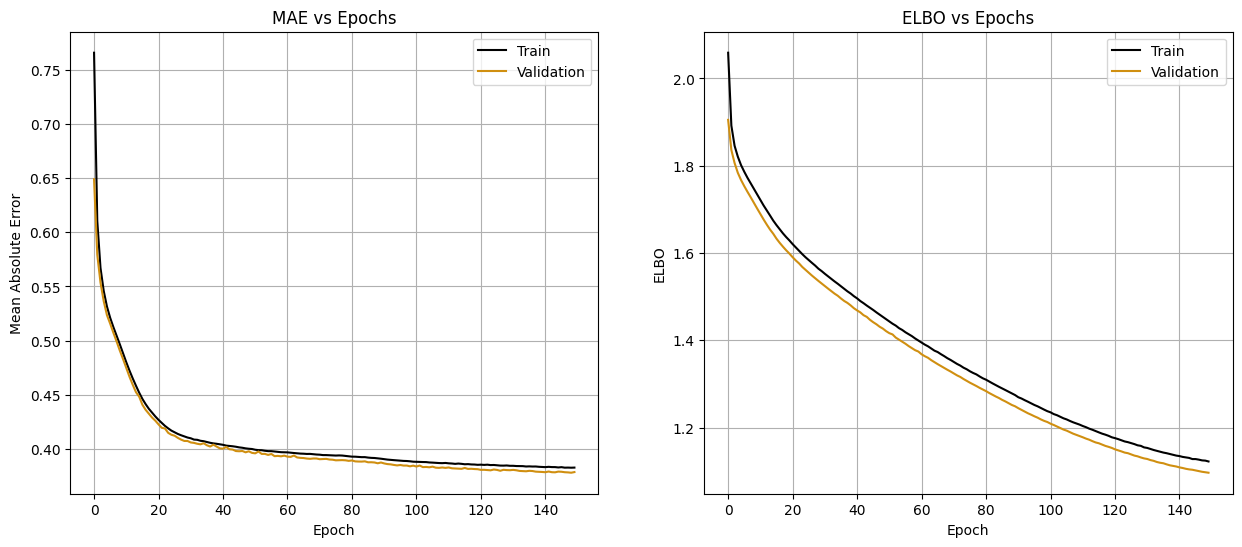

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(bnn_history.history['train_mae'], color='black', label='Train')
axs[0].plot(bnn_history.history['val_mae'], color='#d08f10ff', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Absolute Error')
axs[0].set_title('MAE vs Epochs')
axs[0].legend()
axs[0].grid()

axs[1].plot(bnn_history.history['train_elbo'], color='black', label='Train')
axs[1].plot(bnn_history.history['val_elbo'], color='#d08f10ff', label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ELBO')
axs[1].set_title('ELBO vs Epochs')
axs[1].legend()
axs[1].grid()


plt.show()

The BNN get a very good result similar to the simple neural network. However, there is a limitation with this approach: while the gamma distribution parameters are trainable, they do not vary based on the input data. This means that the model learns a single pair of $\alpha$ and $\beta$ values to represent the uncertainty across all predictions, leading to a constant level of uncertainty.  This approach assumes that the uncertainty is the same regardless of the input features, which is often not the case in real-world scenarios. Different input data points can have varying levels of uncertainty, and a model that assumes constant uncertainty might not capture the true underlying variability.

# Two Heads Bayesian Neural Network

To enable our BNN to predict both the target value and the associated uncertainty, we can use a more advanced approach that makes the standard deviation dependent on the input data. This approach involves employing two separate neural networks within the BNN architecture. One network is responsible for predicting the mean value $\mu$ of the target distribution based on the input features $\mathbf{x}$, while the other network predicts the standard deviation $\sigma$, representing the uncertainty of the predictions.

<center><img src="figures/2head-bnn.png" width="800" height="500"></center>

In the image provided, the input data $\mathbf{x}$ is processed through a shared initial set of layers (in red), which then splits into two distinct pathways. The upper pathway (in green) is responsible for predicting the mean $\mu$. The lower pathway (in blue) is dedicated to predicting the standard deviation $\sigma$.By using these two networks, the model can capture varying levels of uncertainty across different regions of the input space. The uncertainty prediction network ensures that the standard deviation is not a fixed value but varies according to the input data, leading to more accurate and reliable uncertainty estimates. This dual-network approach allows the BNN to provide a comprehensive understanding of both the predicted target value and the associated uncertainty.

Having defined the BNN class and the layer class from the previously model, it’s relatively easy to define another class which implements the dual-headed Bayesian density network. We can just define a core network consisting of several layers (in red), and then two sub-networks which receive the output of the core network and output independent predictions. The output of one network we’ll use as the mean predictions, and the output of the other as the standard deviation predictions.

In [64]:
class DualBNNRegressor(Model):
    """
    Multilayer fully-connected Bayesian neural network, with two heads to predict
    both the mean and the standard deviation of the output distribution.

    Parameters
    ----------
    units : List[int]
        Number of output dimensions for each layer in the core network.
    head_units : List[int]
        Number of output dimensions for each layer in the head networks.
    name : None or str
        Name for the layer.
    """

    def __init__(self, core_units, head_units, total_samples, name = None):
        # Initialize the parent class
        super(DualBNNRegressor, self).__init__(name = name)

        # Trackers for training metrics
        self.train_elbo_tracker = Mean(name='train_elbo')
        self.train_mae_tracker = MeanAbsoluteError(name='train_mae')

        # Trackers for validation metrics
        self.val_elbo_tracker = Mean(name='val_elbo')
        self.val_mae_tracker = MeanAbsoluteError(name='val_mae')

        # Create the core network using BayesianNN
        self.core_net = BNN( layer_units = core_units[:-1], 
                                    output_unit = core_units[-1], 
                                    activation_func = 'relu') 
        
        # Create the loc(mean) head network
        self.loc_net = BNN(  layer_units = [core_units[-1]] + head_units[:-1], 
                                    output_unit = head_units[-1],
                                    activation_func = 'relu')    

        # Create the scale (standard deviation) head network
        self.std_net = BNN(  layer_units = [core_units[-1]] + head_units[:-1], 
                                    output_unit = head_units[-1],  
                                    output_activation =  'softplus',
                                    activation_func = 'relu') 
        
        self.total_samples = total_samples
    
    def call(self, x, training = True):

        """
        Executes a forward pass through the network.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output of the network after passing through all the layers.
        """
        # Pass the input through the core network
        x = self.core_net(x,  training = training)

        # Pass the output of the core network through the location and std heads
        loc_preds = self.loc_net(x,  training = training)
        std_preds = self.std_net(x,  training = training)
            
        # Return the output of the location and std heads
        return tf.concat([loc_preds, std_preds], 1)
    

    def train_step(self, data):
        x, y = data
        elbo_loss, preds = self._train_evaluate(x, y)
        y_loc_pred = preds[:, 0]

        self.train_mae_tracker.update_state(y, y_loc_pred)
        self.train_elbo_tracker.update_state(elbo_loss) 

        dict_losses = { "train_mae": self.train_mae_tracker.result(), 
                        "train_elbo":self.train_elbo_tracker.result()}
        return dict_losses
    
    @tf.function
    def _train_evaluate(self, x,  y):
        with tf.GradientTape() as tape:
            log_likelihoods, preds  = self.log_likelihood(x, y)
            elbo_loss = self.total_kl_loss/self.total_samples  - tf.reduce_mean(log_likelihoods)

        grads = tape.gradient(elbo_loss, self.trainable_weights)  
        if self.optimizer != None:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))       

        return elbo_loss, preds
    
    def test_step(self, data):
        x, y = data
        elbo_loss, preds = self._test_evaluate(x, y)
        y_loc_pred = preds[:, 0]
        
        self.val_mae_tracker.update_state(y, y_loc_pred)
        self.val_elbo_tracker.update_state(elbo_loss) 

        dict_losses = { "mae": self.val_mae_tracker.result(), 
                        "elbo":self.val_elbo_tracker.result()}
        return dict_losses
    
    @tf.function
    def _test_evaluate(self, x, y):
        log_likelihoods, preds = self.log_likelihood(x, y, training=False)
        elbo_loss = self.total_kl_loss / self.total_samples - tf.reduce_mean(log_likelihoods)
        return elbo_loss, preds

     
    def log_likelihood(self, x, y, training = True):
        
        preds = self.call(x, training = training)
        # Ensure consistent dtypes
        loc = tf.cast(preds[:, 0], dtype=tf.float32)
        std = tf.cast(preds[:, 1], dtype=tf.float32)
        y = tf.cast(y[:, 0], dtype=tf.float32)
        
        log_likelihood = tfd.Normal(loc, std).log_prob(y)
        # Return log likelihood of true df_taxi given predictions
        return  log_likelihood, preds
    
    
    @tf.function
    def sample(self, x):
        preds = self.call(x)
        loc, std = preds[:, 0], preds[:, 1]
        return tfp.distributions.Normal(loc, std).sample()
    
    def samples(self, x, n_sample = 1):
        N = x.shape[0]
        samples = np.zeros((N, n_sample))

        for i in range(n_sample):
           samples[:,i] = self.sample(x)
        return samples
    
    @property
    def total_kl_loss(self):
        # KL-loss from the networks
        core_kl_loss = self.core_net.network_losses
        loc_kl_loss = self.loc_net.network_losses
        std_kl_loss = self.std_net.network_losses
        return core_kl_loss + loc_kl_loss + std_kl_loss

In [65]:
# Initialize and compile the model
dual_bnn_regressor = DualBNNRegressor([7, 256, 128], [64, 32, 1], X_train.shape[0])
dual_bnn_regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# Train the model using the manually created datasets
dualbnn_history = dual_bnn_regressor.fit(X_train, Y_train[:, None], batch_size=1024, epochs=150, validation_data=(X_val, Y_val[:, None]), verbose=1)


# Save Model
current_directory = os.getcwd()
save_dir = os.path.expanduser( current_directory + '/models/dual_bnn_regressor')
dual_bnn_regressor.save(save_dir)

Epoch 1/150
382/382 [==============================] - 12s 22ms/step - train_mae: 0.7402 - train_elbo: 2.6993 - val_mae: 0.6680 - val_elbo: 2.5004
Epoch 2/150
382/382 [==============================] - 8s 21ms/step - train_mae: 0.6291 - train_elbo: 2.4323 - val_mae: 0.6053 - val_elbo: 2.3832
Epoch 3/150
382/382 [==============================] - 8s 21ms/step - train_mae: 0.5883 - train_elbo: 2.3527 - val_mae: 0.5712 - val_elbo: 2.3177
Epoch 4/150
382/382 [==============================] - 8s 21ms/step - train_mae: 0.5574 - train_elbo: 2.2867 - val_mae: 0.5406 - val_elbo: 2.2490
Epoch 5/150
382/382 [==============================] - 8s 21ms/step - train_mae: 0.5317 - train_elbo: 2.2275 - val_mae: 0.5224 - val_elbo: 2.2054
Epoch 6/150
382/382 [==============================] - 8s 21ms/step - train_mae: 0.5167 - train_elbo: 2.1902 - val_mae: 0.5085 - val_elbo: 2.1685
Epoch 7/150
382/382 [==============================] - 8s 21ms/step - train_mae: 0.5038 - train_elbo: 2.1588 - val_mae: 0.4

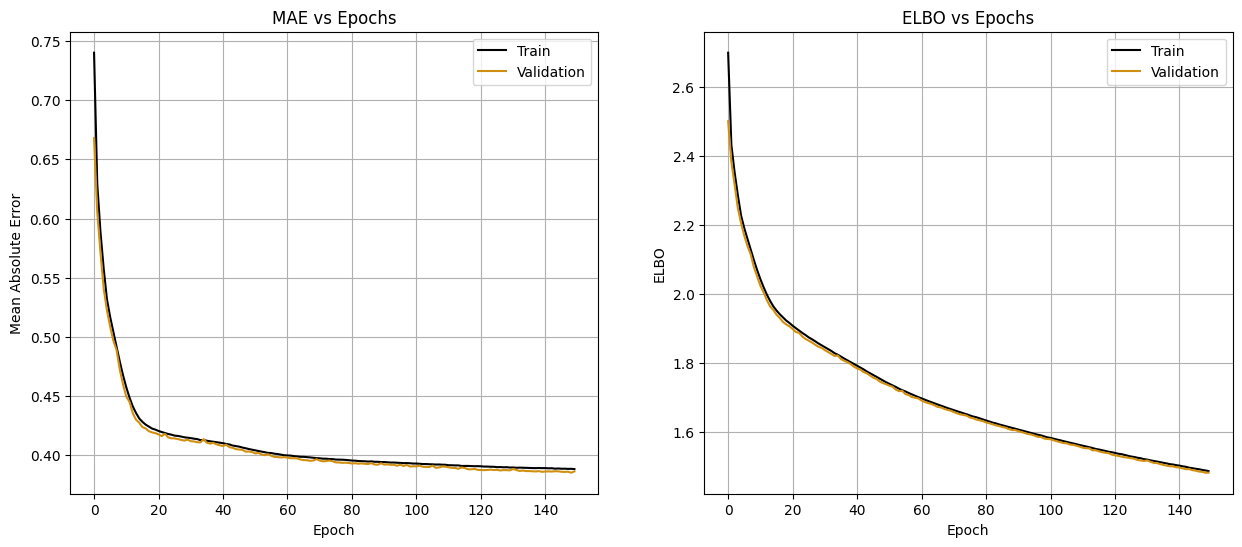

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(dualbnn_history.history['train_mae'], color='black', label='Train')
axs[0].plot(dualbnn_history.history['val_mae'], color='#d08f10ff', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Absolute Error')
axs[0].set_title('MAE vs Epochs')
axs[0].legend()
axs[0].grid()

axs[1].plot(dualbnn_history.history['train_elbo'], color='black', label='Train')
axs[1].plot(dualbnn_history.history['val_elbo'], color='#d08f10ff', label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ELBO')
axs[1].set_title('ELBO vs Epochs')
axs[1].legend()
axs[1].grid()


plt.show()

# Model Evaluation

In [83]:
# Load Models
current_directory = os.getcwd()
nn_path = os.path.expanduser( current_directory + '/models/nn_regressor')
bnn_path = os.path.expanduser( current_directory + '/models/bnn_regressor')
dual_bnn_path = os.path.expanduser( current_directory + '/models/dual_bnn_regressor')


nn_regressor = tf.keras.models.load_model(nn_path, custom_objects={'NNRegressor': NNRegressor})
bnn_regressor = tf.keras.models.load_model(bnn_path, custom_objects={'DenseFlipout': DenseFlipout, 'BNN': BNN, 'BNNRegressor': BNNRegressor})
dual_bnn_regressor = tf.keras.models.load_model(dual_bnn_path, custom_objects={'DenseFlipout': DenseFlipout, 'BNN': BNN, 'DualBNNRegressor': DualBNNRegressor})


## Learning Curves

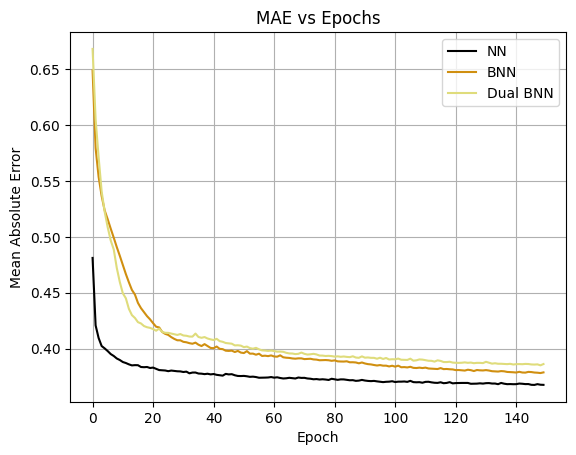

In [80]:
# Plot error vs epoch curves for all 3 models
plt.plot(nn_history.history['val_loss'], color="black", label='NN')
plt.plot(bnn_history.history['val_mae'],color="#d08f10ff",   label='BNN')
plt.plot(dualbnn_history.history['val_mae'],color="#dfdc7bff" ,  label='Dual BNN')
plt.title('MAE vs Epochs')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()


## Residuals

12202/12202 [==============================] - 18s 1ms/step


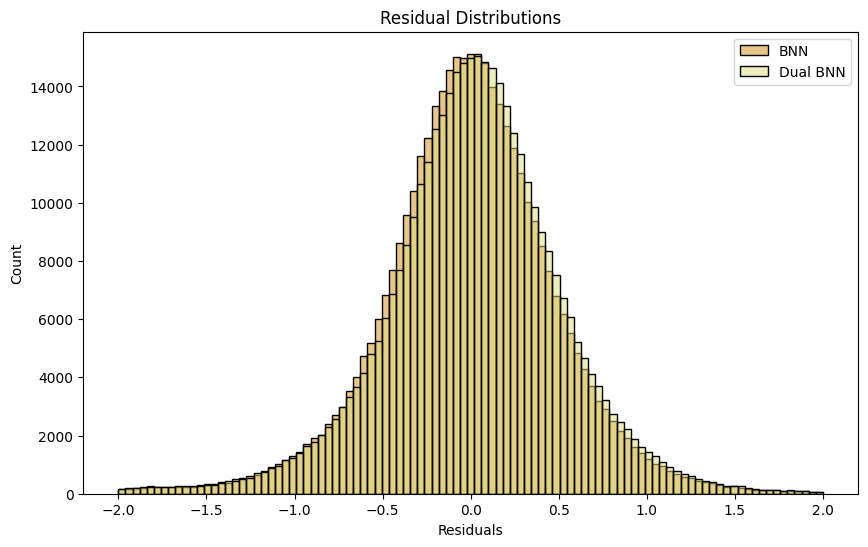

In [84]:
# Make predictions on test data
y_test_pred_bnn = bnn_regressor.predict(X_test)
y_test_pred_dual_bnn = dual_bnn_regressor.predict(X_test)

# Calculate residuals
resids1 = Y_test - y_test_pred_bnn[:, 0]
resids2 = Y_test - y_test_pred_dual_bnn[:, 0]

# Plot residual distributions using Seaborn
plt.figure(figsize=(10, 6))
bins = np.linspace(-2, 2, 100)
sns.histplot(resids1, bins=bins, linewidth=1, color="#d08f10ff", alpha=0.5, label='BNN')
sns.histplot(resids2, bins=bins, linewidth=1, color="#dfdc7bff", alpha=0.5, label='Dual BNN')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residual Distributions')
plt.show()

# Predictive Distributions

In [69]:
dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(1024)

# Iterate through the dataset batches
for batch in dataset:
    bnn_samples = bnn_regressor.samples(batch, n_sample=1000)
    dual_bnn_samples = dual_bnn_regressor.samples(batch, n_sample=1000)

KeyboardInterrupt: 

In [ ]:
## Plot predictive distributions
#plt.figure(figsize=(12, 10))
#for i in range(8):
#    plt.subplot(4, 2, i + 1)
#    sns.kdeplot(samples1[i, :], shade=True, color="#dfdc7bff", label='Model 1', alpha=0.5)
#    sns.kdeplot(samples2[i, :], shade=True, color="#d08f10ff", label='Model 2', alpha=0.5)
#    plt.axvline(Y_val[i], ls=':', color='gray')
#    plt.xlim([-5, 5])
#    plt.ylim([0, 2.2])
#    plt.title(f'Sample {i}')
#    plt.gca().get_yaxis().set_ticklabels([])
#    if i < 6:
#        plt.gca().get_xaxis().set_ticklabels([])
#    if i == 0:
#        plt.legend()
#
#plt.tight_layout()
#plt.show()